# Notebook Starting

### Install detectron2

In [1]:
# install dependencies: 
!pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 8.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [34 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "/tmp/pip-install-2_2y4ru6/pyyaml_acf32c22ad1046609416e0f993c464fe/setup.py", line 291, in <module>
          setup(
        File "/opt/conda/lib/python3.10/site-packages/setuptools/_distutils/core.py", line 185, in setup
          return run_commands(dist)
        File "/opt/conda/lib/python3.10/site-packages/setuptools/_distutils/core.py", line 201, in run_commands
          dist.run_commands()
        File "/opt/conda/lib/python3.10/site-packages/setuptools/_distutils/dist.py", line 969, in run_commands
          self.run_command(cmd)
        File "/opt/conda/lib/

In [2]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'


  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-95d36eht
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-95d36eht
  Resolved https://github.com/facebookresearch/detectron2.git to commit 70f454304e1a38378200459dd2dbca0f0f4a5ab4
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.8/427.8 kB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1

In [3]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
# from google.colab.patches import cv2_imshow
from IPython import display
import PIL


# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog


def cv2_imshow(a):
    """A replacement for cv2.imshow() for use in Jupyter notebooks.
    Args:
    a : np.ndarray. shape (N, M) or (N, M, 1) is an NxM grayscale image. shape
      (N, M, 3) is an NxM BGR color image. shape (N, M, 4) is an NxM BGRA color
      image.
    """
    a = a.clip(0, 255).astype('uint8')
    # cv2 stores colors as BGR; convert to RGB
    if a.ndim == 3:
        if a.shape[2] == 4:
            a = cv2.cvtColor(a, cv2.COLOR_BGRA2RGBA)
        else:
            a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
    display.display(PIL.Image.fromarray(a))

## Prepare the dataset

In [4]:
import pandas as pd 
tt= pd.read_csv('/kaggle/input/arm-unicef-disaster-vulnerability-challenge-data/Train.csv')
tt.category_id.value_counts()

category_id
2.0    21330
3.0     2348
1.0      171
Name: count, dtype: int64

## Preparing the annotation.json for the Detectron2 ( Read Git Documentation ) [From my xml data]

In [5]:
import os
import json
import xml.etree.ElementTree as ET

# Define paths
annotations_dir = "/kaggle/input/annotations-grouped"  # Update this path to your annotations directory
images_dir = "/kaggle/input/arm-unicef-disaster-vulnerability-challenge-data/Images"                # Update this path to your images directory
output_json = "annotations.json"             # Output JSON file

# Initialize the COCO structure
coco_data = {
    "licenses": [{"name": "", "id": 0, "url": ""}],
    "info": {"contributor": "", "date_created": "", "description": "", "url": "", "version": "", "year": ""},
    "categories": [
            {"id":0,
              "name": "other"}
            ,{"id":1,
              "name": "tin"}
            ,{"id":2,
              "name": "thatch"}],
    "images": [],
    "annotations": []
}

image_id = 0
annotation_id = 1
image_id_mapper={}
mapper = {'other':0,'tin':1,'thatch':2}

# Function to parse XML files
def parse_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    
    filename = root.find("filename").text
    size = root.find("size")
    width = int(size.find("width").text)
    height = int(size.find("height").text)
    depth = int(size.find("depth").text)
    category_id =0

    bboxes = []
    categories = []
    for obj in root.findall("object"):
        category = obj.find("name").text
#         print('category',category)
        
        if category :  # Ensure category matches the one defined in COCO format
            category_id = mapper[category]

            bbox = obj.find("bndbox")
            
            xmin = float(bbox.find("xmin").text)
            ymin = float(bbox.find("ymin").text)
            xmax = float(bbox.find("xmax").text)
            ymax = float(bbox.find("ymax").text)
            categories.append(category_id)
            bboxes.append((xmin, ymin, xmax - xmin, ymax - ymin))
    
    return filename, width, height, categories, bboxes


# Loop through all XML files in the annotations directory
for xml_file in os.listdir(annotations_dir):
    if xml_file.endswith(".xml"):
        xml_path = os.path.join(annotations_dir, xml_file)
        filename, width, height, categories, bboxes = parse_xml(xml_path)
        
        
        if bboxes==[]:
            continue
        image_id +=1

        # Add image information
        coco_data["images"].append({
            "id": image_id,
            "width": width,
            "height": height,
            "file_name": filename,
            "license": 0,
            "flickr_url": "",
            "coco_url": "",
            "date_captured": 0
        })
        
        # Add annotations
        for idx, bbox in enumerate(bboxes):
            category_id = categories[idx]
#             print('bbox',bbox)
            xmin, ymin, w, h = bbox
            area = w * h
            coco_data["annotations"].append({
                "id": annotation_id,
                "image_id": image_id,
                "category_id": category_id,
                "segmentation": [],
                "area": area,
                "bbox": [xmin, ymin, w, h],
                "iscrowd": 0,
                "attributes": {"occluded": False}
            })
            annotation_id += 1
        
        

# Save to JSON file
with open(output_json, "w") as json_file:
    json.dump(coco_data, json_file, indent=4)

print(f"Annotations saved to {output_json}")


Annotations saved to annotations.json


In [6]:
coco_data['annotations'][-1]

{'id': 23849,
 'image_id': 2465,
 'category_id': 1,
 'segmentation': [],
 'area': 1634.0,
 'bbox': [19.0, 397.0, 43.0, 38.0],
 'iscrowd': 0,
 'attributes': {'occluded': False}}

## Registering the data for the model to interact with as dataset

In [7]:
from detectron2.data.datasets import register_coco_instances
from detectron2.structures import BoxMode

# Step 1: Delete the existing dataset registration if needed
dataset_name = "zindi_"
if dataset_name in MetadataCatalog.list():
    MetadataCatalog.remove(dataset_name)
if dataset_name in DatasetCatalog.list():
    DatasetCatalog.remove(dataset_name)

register_coco_instances(f"zindi_", {},
                            f"/kaggle/working/annotations.json",
                            f"/kaggle/input/arm-unicef-disaster-vulnerability-challenge-data/Images")

## Visualinzing some data samples

WARNING [06/23 17:32:26 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/23 17:32:26 d2.data.datasets.coco]: Loaded 2465 images in COCO format from /kaggle/working/annotations.json
Sample: {'file_name': '/kaggle/input/arm-unicef-disaster-vulnerability-challenge-data/Images/id_xwsg7nei091s.tif', 'height': 500, 'width': 500, 'image_id': 1892, 'annotations': [{'iscrowd': 0, 'bbox': [377.0, 85.0, 50.0, 43.0], 'category_id': 0, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'iscrowd': 0, 'bbox': [478.0, 294.0, 21.0, 31.0], 'category_id': 1, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'iscrowd': 0, 'bbox': [450.0, 95.0, 24.0, 27.0], 'category_id': 0, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}]}
Filename: /kaggle/input/arm-unicef-disaster-vulnerability-challenge-data/Images/id_xwsg7nei091s.tif


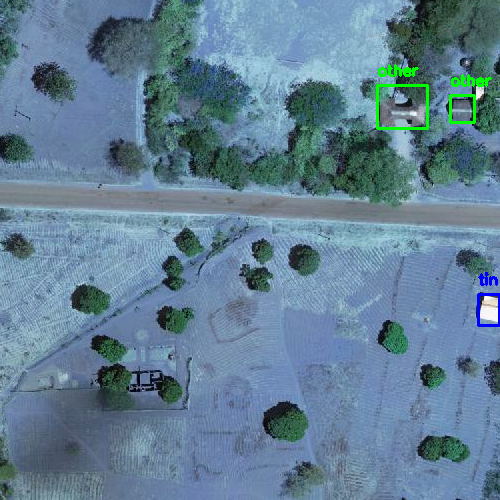

Sample: {'file_name': '/kaggle/input/arm-unicef-disaster-vulnerability-challenge-data/Images/id_83z7vniaf8mz.tif', 'height': 1000, 'width': 1000, 'image_id': 1724, 'annotations': [{'iscrowd': 0, 'bbox': [526.0, 723.0, 43.0, 42.0], 'category_id': 1, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'iscrowd': 0, 'bbox': [792.0, 863.0, 41.0, 36.0], 'category_id': 1, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}]}
Filename: /kaggle/input/arm-unicef-disaster-vulnerability-challenge-data/Images/id_83z7vniaf8mz.tif


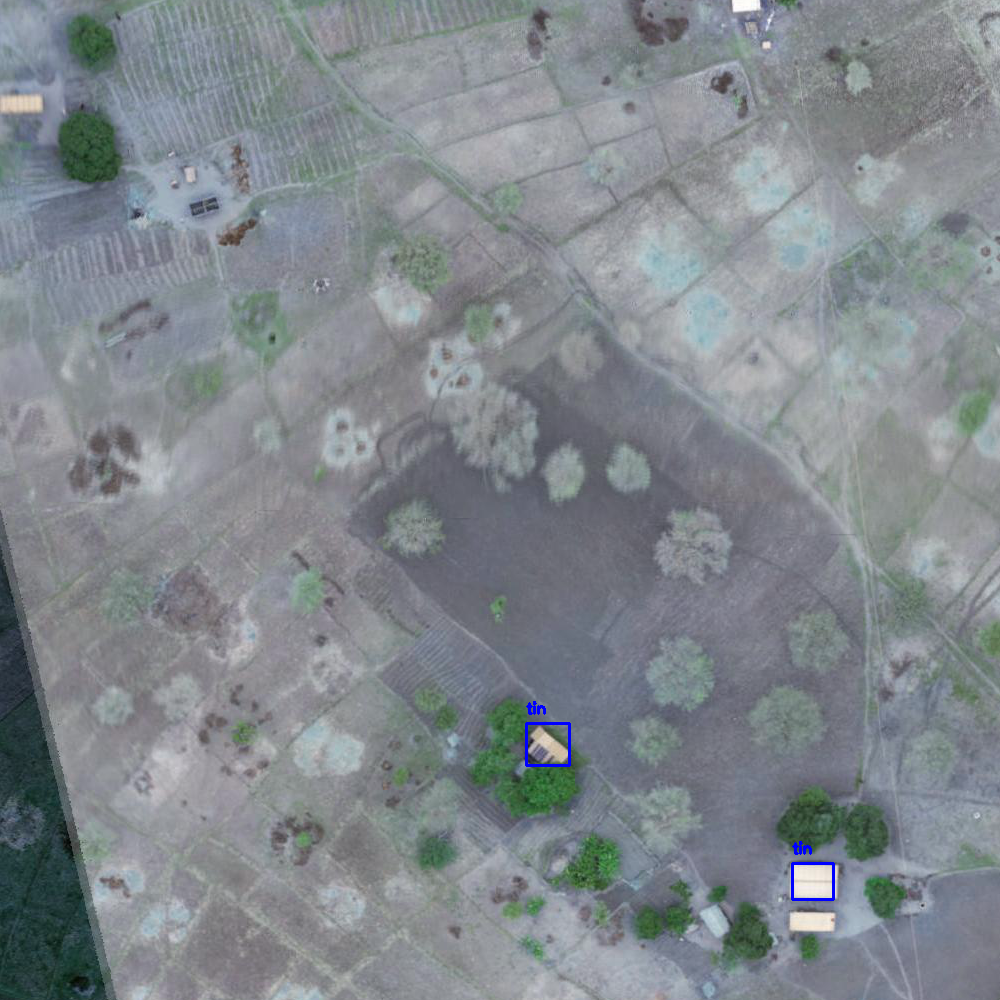

Sample: {'file_name': '/kaggle/input/arm-unicef-disaster-vulnerability-challenge-data/Images/id_xubq8ivjvwl9.tif', 'height': 1000, 'width': 1000, 'image_id': 1318, 'annotations': [{'iscrowd': 0, 'bbox': [489.0, 459.0, 74.0, 70.0], 'category_id': 1, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}]}
Filename: /kaggle/input/arm-unicef-disaster-vulnerability-challenge-data/Images/id_xubq8ivjvwl9.tif


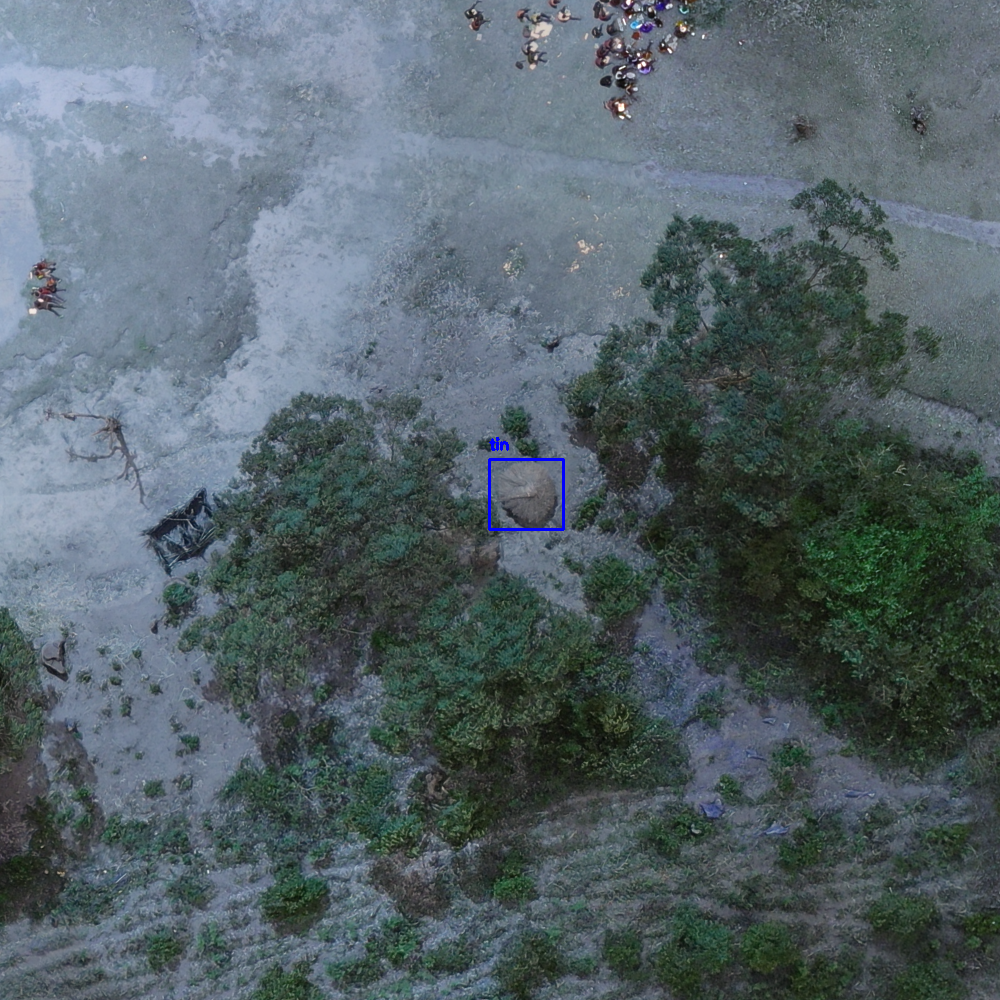

In [8]:
#visualize training data
my_dataset_train_metadata = MetadataCatalog.get("zindi_")
dataset_dicts = DatasetCatalog.get("zindi_")

import random
from detectron2.utils.visualizer import Visualizer

# Define custom colors for each category
custom_colors = {
    0: (0, 255, 0),   # Green for 'other'
    1: (255, 0, 0),   # Blue for 'tin'
    2: (0, 0, 255)    # Red for 'thatch'
}
# Define category names for labeling
category_names = {
    0: "other",
    1: "tin",
    2: "thatch"
}

# Function to visualize the dataset with consistent colors and labels
def visualize_sample(d, metadata, colors, category_names):
    print('Sample:', d)
    print('Filename:', d["file_name"])
    
    # Read the image file
    img = cv2.imread(d["file_name"])
    
    # Create a Visualizer object
    visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, scale=0.5)
    
    # Draw the dataset dictionary
    vis = visualizer.draw_dataset_dict(d)
    
    # Apply custom colors and labels to the annotations
    for annotation in d['annotations']:
        category_id = annotation['category_id']
        color = colors.get(category_id, (255, 255, 255))  # Default to white if not found
        bbox = annotation['bbox']
        bbox_mode = BoxMode(annotation['bbox_mode'])
        bbox_color = color[::-1]  # Convert to BGR format for OpenCV
        
        # Draw bounding box with the specified color
        if bbox_mode == BoxMode.XYWH_ABS:
            start_point = (int(bbox[0]), int(bbox[1]))
            end_point = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
            img = cv2.rectangle(img, start_point, end_point, bbox_color, 2)
            
            # Put category label
            label = category_names.get(category_id, "unknown")
            label_position = (int(bbox[0]), int(bbox[1] - 10))  # Position above the box
            img = cv2.putText(img, label, label_position, cv2.FONT_HERSHEY_SIMPLEX, 0.5, bbox_color, 2)
    
    # Display the visualized image
    cv2_imshow(img[:, :, ::-1])  # Use cv2.imshow() if not in Colab

# Visualize a random sample from the dataset
for d in random.sample(dataset_dicts, 3):
    visualize_sample(d, my_dataset_train_metadata, custom_colors, category_names)
 

# Training 


In [9]:
import os
import tensorflow as tf
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Ensure TensorFlow can see the GPU
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


2024-06-23 17:32:30.084424: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-23 17:32:30.084530: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-23 17:32:30.211543: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Num GPUs Available:  1


In [10]:
!rm -rf /kaggle/working/output

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [11]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))#faster_rcnn_R_50_FPN_3x
cfg.DATASETS.TRAIN = ("zindi_",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 1
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 1e-3  # pick a good LR
cfg.SOLVER.MAX_ITER = 300   # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3  

# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.
cfg.MODEL.DEVICE = "cuda"

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
# uncomment below to train
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[06/23 17:32:43 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_68b088.pkl: 421MB [00:01, 232MB/s]                           


[06/23 17:32:46 d2.engine.train_loop]: Starting training from iteration 0


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[06/23 17:33:08 d2.utils.events]:  eta: 0:04:33  iter: 19  total_loss: 1.997  loss_cls: 1.335  loss_box_reg: 0.3324  loss_rpn_cls: 0.3099  loss_rpn_loc: 0.03042    time: 0.9559  last_time: 0.9356  data_time: 0.0192  last_data_time: 0.0055   lr: 6.427e-05  max_mem: 3897M
[06/23 17:33:27 d2.utils.events]:  eta: 0:04:04  iter: 39  total_loss: 1.307  loss_cls: 0.6529  loss_box_reg: 0.4815  loss_rpn_cls: 0.08779  loss_rpn_loc: 0.03707    time: 0.9391  last_time: 0.9973  data_time: 0.0057  last_data_time: 0.0050   lr: 0.00013087  max_mem: 3898M
[06/23 17:33:45 d2.utils.events]:  eta: 0:03:44  iter: 59  total_loss: 1.225  loss_cls: 0.4818  loss_box_reg: 0.652  loss_rpn_cls: 0.05307  loss_rpn_loc: 0.03446    time: 0.9249  last_time: 0.8347  data_time: 0.0057  last_data_time: 0.0056   lr: 0.00019747  max_mem: 3898M
[06/23 17:34:02 d2.utils.events]:  eta: 0:03:24  iter: 79  total_loss: 1.065  loss_cls: 0.3593  loss_box_reg: 0.629  loss_rpn_cls: 0.02366  loss_rpn_loc: 0.03225    time: 0.9087  las

In [12]:
# Save the final model

final_checkpoint = os.path.join(cfg.OUTPUT_DIR, "detectron2_100XResnet_zindi_1000.pth")
trainer.checkpointer.save("detectron2_100XResnet_zindi_1000")

In [13]:
import shutil

# shutil.make_archive('Output_detectrone2','zip','/kaggle/working/output')

In [14]:
!ls /kaggle/working/output

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


detectron2_100XResnet_zindi_1000.pth		  metrics.json
events.out.tfevents.1719163988.801662d2485c.24.0  model_final.pth
last_checkpoint


## Metrics evaluation

In [15]:
import pandas as pd

# Read the JSON file
metrics_df = pd.read_json('/kaggle/working/output/metrics.json', lines=True)

# Display the DataFrame
metrics_df.head()


data_time  eta_seconds  fast_rcnn/cls_accuracy  fast_rcnn/false_negative  \
0   0.005737   273.568606                0.273438                  0.021441   
1   0.005520   244.080700                0.841797                  1.000000   
2   0.005633   224.636975                0.804688                  1.000000   
3   0.005749   204.884045                0.898438                  0.439542   
4   0.005398   186.059820                0.916016                  0.279221   

   fast_rcnn/fg_cls_accuracy  iteration  loss_box_reg  loss_cls  loss_rpn_cls  \
0                   0.851437         19      0.332403  1.334815      0.309915   
1                   0.000000         39      0.481500  0.652861      0.087794   
2                   0.000000         59      0.651971  0.481762      0.053071   
3                   0.545660         79      0.629043  0.359292      0.023658   
4                   0.703978         99      0.495453  0.244028      0.026959   

   loss_rpn_loc        lr  rank_data_time  roi_head/num_bg_samples  \
0      0.030417  0.000064        0.005737                   227.25   
1      0.037069  0.000131        0.005520                   215.25   
2      0.034456  0.000197        0.005633                   206.00   
3      0.032254  0.000264        0.005749                   205.75   
4      0.032443  0.000331        0.005398                   213.75   

   roi_head/num_fg_samples  rpn/num_neg_anchors  rpn/num_pos_anchors  \
0                    28.75               233.75                22.25   
1                    40.75               222.50                33.50   
2                    50.00               227.25                28.75   
3                    50.25               223.00                33.00   
4                    42.25               232.00                24.00   

       time  total_loss  
0  0.977031    1.997120  
1  0.932815    1.307490  
2  0.927301    1.225320  
3  0.838174    1.064976  
4  0.843002    0.875318

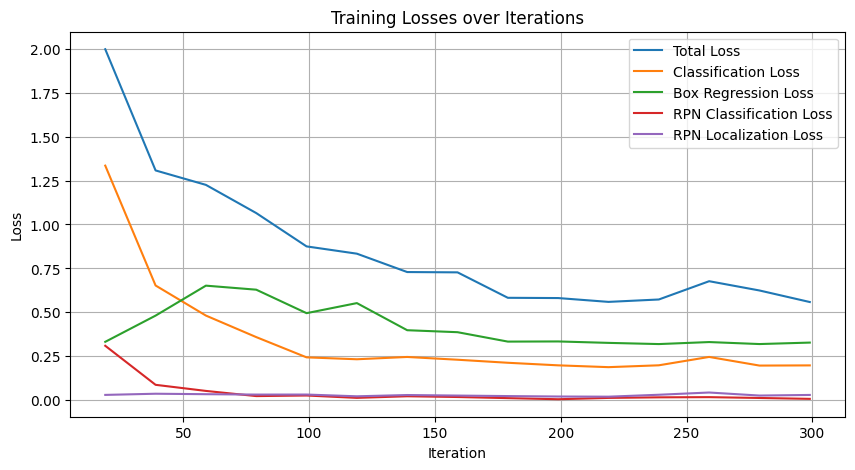

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

# Plot total loss
plt.plot(metrics_df['iteration'], metrics_df['total_loss'], label='Total Loss')
plt.plot(metrics_df['iteration'], metrics_df['loss_cls'], label='Classification Loss')
plt.plot(metrics_df['iteration'], metrics_df['loss_box_reg'], label='Box Regression Loss')
plt.plot(metrics_df['iteration'], metrics_df['loss_rpn_cls'], label='RPN Classification Loss')
plt.plot(metrics_df['iteration'], metrics_df['loss_rpn_loc'], label='RPN Localization Loss')

plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Losses over Iterations')
plt.legend()
plt.grid(True)
plt.show()


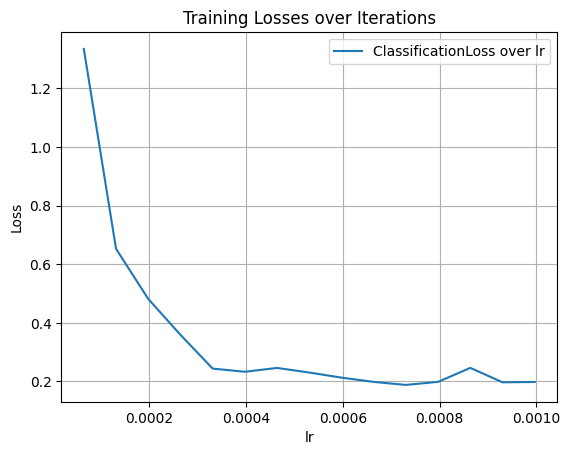

In [17]:
plt.plot(metrics_df['lr'], metrics_df['loss_cls'], label='ClassificationLoss over lr')

plt.xlabel('lr')
plt.ylabel('Loss')
plt.title('Training Losses over Iterations')
plt.legend()
plt.grid(True)
plt.show()


# Prediciton Visualization

[06/23 17:37:26 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /kaggle/working/output/model_final.pth ...
Sample: {'file_name': '/kaggle/input/arm-unicef-disaster-vulnerability-challenge-data/Images/id_cijxujabmxnp.tif', 'height': 1000, 'width': 1000, 'image_id': 1911, 'annotations': [{'iscrowd': 0, 'bbox': [416.0, 350.0, 124.0, 150.0], 'category_id': 1, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'iscrowd': 0, 'bbox': [812.0, 238.0, 75.0, 72.0], 'category_id': 1, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'iscrowd': 0, 'bbox': [489.0, 734.0, 409.0, 265.0], 'category_id': 1, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'iscrowd': 0, 'bbox': [551.0, 216.0, 202.0, 179.0], 'category_id': 1, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}]}
Filename: /kaggle/input/arm-unicef-disaster-vulnerability-challenge-data/Images/id_cijxujabmxnp.tif


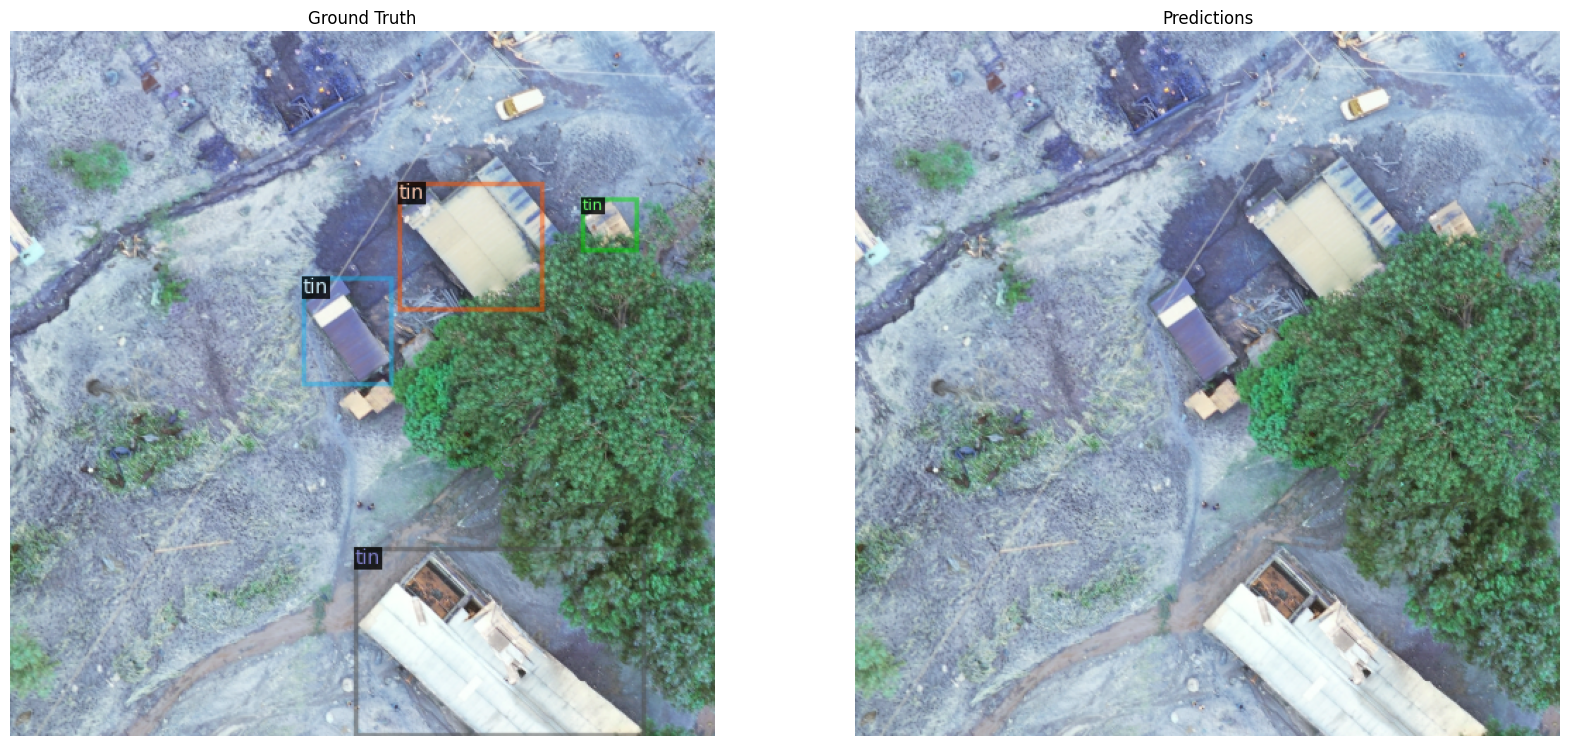

Sample: {'file_name': '/kaggle/input/arm-unicef-disaster-vulnerability-challenge-data/Images/id_lb94ruxzvbz6.tif', 'height': 500, 'width': 500, 'image_id': 823, 'annotations': [{'iscrowd': 0, 'bbox': [105.0, 295.0, 30.0, 30.0], 'category_id': 1, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'iscrowd': 0, 'bbox': [49.0, 296.0, 44.0, 42.0], 'category_id': 1, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'iscrowd': 0, 'bbox': [231.0, 273.0, 38.0, 45.0], 'category_id': 1, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'iscrowd': 0, 'bbox': [372.0, 347.0, 33.0, 28.0], 'category_id': 1, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'iscrowd': 0, 'bbox': [152.0, 179.0, 40.0, 33.0], 'category_id': 1, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'iscrowd': 0, 'bbox': [132.0, 355.0, 50.0, 36.0], 'category_id': 1, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'iscrowd': 0, 'bbox': [322.0, 422.0, 26.0, 29.0], 'category_id': 1, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'iscrowd': 0, 'bbox': [138.0, 470.0, 48.0, 29.0], 'category_id': 1, 'bbox_mode': 

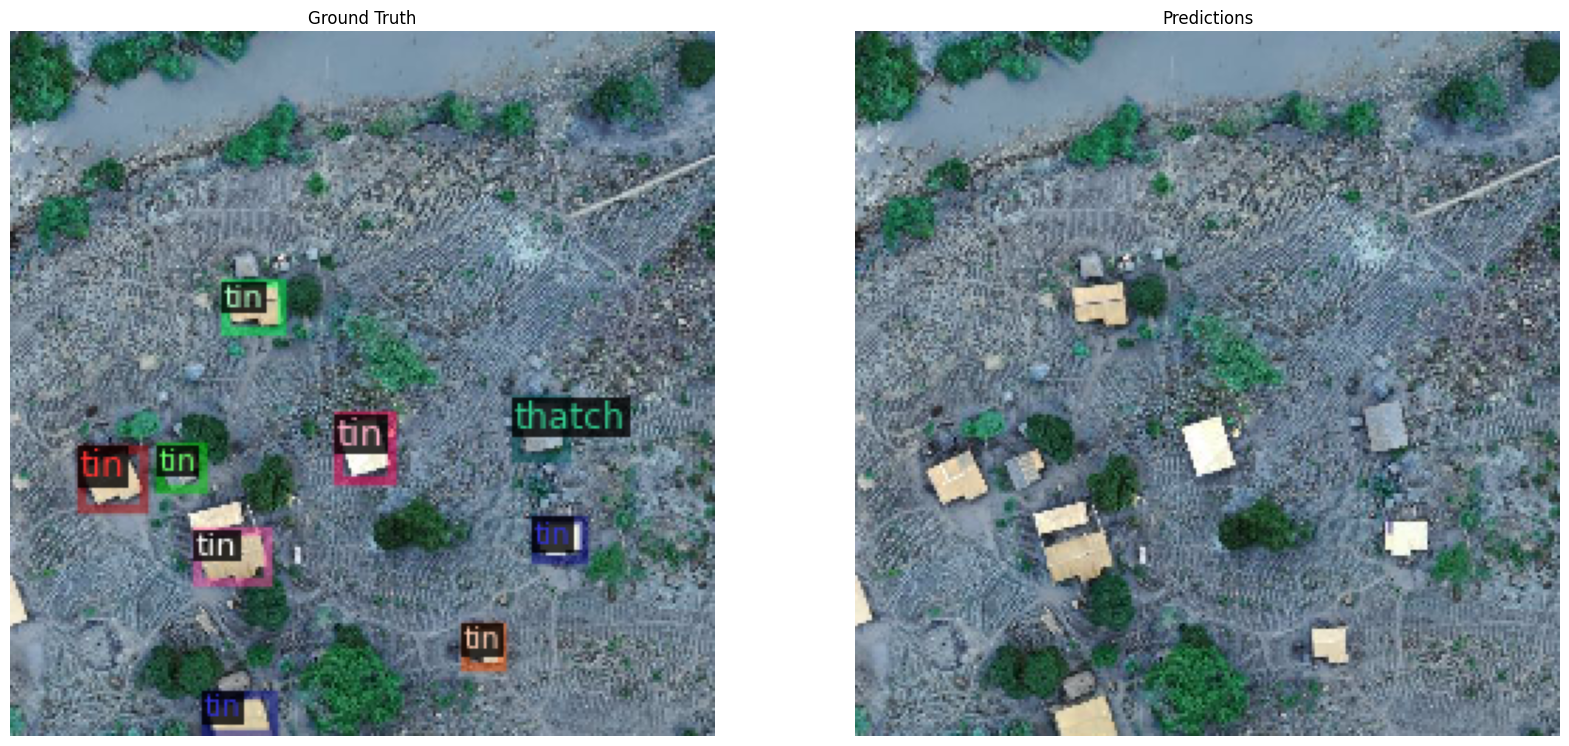

Sample: {'file_name': '/kaggle/input/arm-unicef-disaster-vulnerability-challenge-data/Images/id_jm2r5oxzq8vb.tif', 'height': 1000, 'width': 1000, 'image_id': 886, 'annotations': [{'iscrowd': 0, 'bbox': [401.0, 481.0, 67.0, 83.0], 'category_id': 1, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'iscrowd': 0, 'bbox': [77.0, 796.0, 64.0, 80.0], 'category_id': 1, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'iscrowd': 0, 'bbox': [358.0, 726.0, 56.0, 63.0], 'category_id': 1, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'iscrowd': 0, 'bbox': [444.0, 599.0, 71.0, 88.0], 'category_id': 1, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'iscrowd': 0, 'bbox': [203.0, 674.0, 78.0, 67.0], 'category_id': 1, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'iscrowd': 0, 'bbox': [0.0, 88.0, 61.0, 98.0], 'category_id': 1, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'iscrowd': 0, 'bbox': [135.0, 256.0, 99.0, 99.0], 'category_id': 1, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'iscrowd': 0, 'bbox': [457.0, 935.0, 83.0, 64.0], 'category_id': 1, 'bbox_mode': <

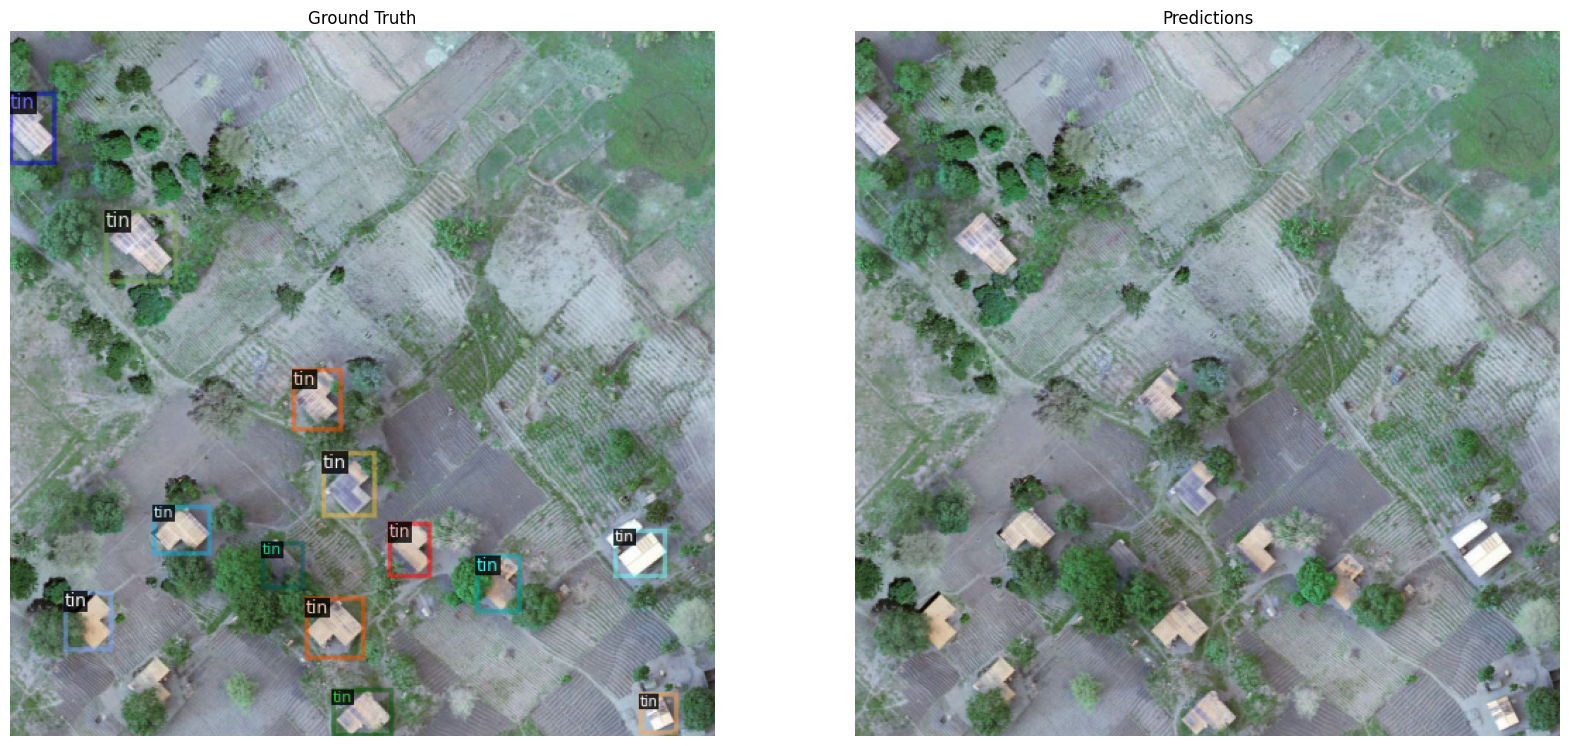

In [18]:
import cv2
import random
import matplotlib.pyplot as plt
import numpy as np
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.structures import BoxMode
import cv2
import numpy as np
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2 import model_zoo
import os
import tifffile
import matplotlib.pyplot as plt

# Step 1: Load the configuration and weights
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = '/kaggle/working/output/model_final.pth'#os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the trained model
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.4  # set a custom testing threshold
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3  # Make sure this matches the number of classes in your dataset
cfg.MODEL.DEVICE = "cuda"  # or "cpu" if you are not using a GPU

predictor = DefaultPredictor(cfg)


def visualize_sample(d, metadata, colors, category_names):
    print('Sample:', d)
    print('Filename:', d["file_name"])
    
    # Read the image file
    img = cv2.imread(d["file_name"])
    
    # Create a Visualizer object for ground truth
    visualizer_gt = Visualizer(img[:, :, ::-1], metadata=metadata, scale=0.5)
    vis_gt = visualizer_gt.draw_dataset_dict(d)
    
    # Create a Visualizer object for predictions
    visualizer_pred = Visualizer(img[:, :, ::-1], metadata=metadata, scale=0.5)
    outputs = predictor(img)
    instances = outputs["instances"].to("cpu")  # Move to CPU
    instances = instances[instances.scores > 0.5]  # Filter out instances with low confidence scores
    vis_pred = visualizer_pred.draw_instance_predictions(instances)
    
    # Apply custom colors and labels to the ground truth annotations
    for annotation in d['annotations']:
        category_id = annotation['category_id']
        color = colors.get(category_id, (255, 255, 255))  # Default to white if not found
        bbox = annotation['bbox']
        bbox_mode = BoxMode(annotation['bbox_mode'])
        bbox_color = color[::-1]  # Convert to BGR format for OpenCV
        
        # Draw bounding box with the specified color
        if bbox_mode == BoxMode.XYWH_ABS:
            start_point = (int(bbox[0]), int(bbox[1]))
            end_point = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
            img = cv2.rectangle(img, start_point, end_point, bbox_color, 2)
            
            # Put category label
            label = category_names.get(category_id, "unknown")
            label_position = (int(bbox[0]), int(bbox[1] - 10))  # Position above the box
            img = cv2.putText(img, label, label_position, cv2.FONT_HERSHEY_SIMPLEX, 0.5, bbox_color, 2)
    
    # Display the images side by side using matplotlib
    plt.figure(figsize=(20, 10))
    
    # Ground truth image
    plt.subplot(1, 2, 1)
    plt.title("Ground Truth")
    plt.imshow(vis_gt.get_image()[:, :, ::-1])
    plt.axis('off')
    
    # Prediction image
    plt.subplot(1, 2, 2)
    plt.title("Predictions")
    plt.imshow(vis_pred.get_image()[:, :, ::-1])
    plt.axis('off')
    
    plt.show()

# Example usage with random sample from the dataset
for d in random.sample(dataset_dicts, 3):
    visualize_sample(d, my_dataset_train_metadata, custom_colors, category_names)

# Final prediction on test data

In [19]:
test = pd.read_csv('/kaggle/input/arm-unicef-disaster-vulnerability-challenge-data/Test.csv')
sub = pd.read_csv('/kaggle/input/arm-unicef-disaster-vulnerability-challenge-data/SampleSubmission.csv')

In [20]:
PATH_DIR = '/kaggle/input/arm-unicef-disaster-vulnerability-challenge-data/Images/'
for image_id in test.image_id:
    PATH_IM = PATH_DIR + image_id +'.tif'
    
    im = tifffile.imread(PATH_IM)

    # Convert the image to a format that OpenCV can use (if necessary)
    # Detectron2 expects the image to be in HWC format with 3 color channels
    if len(im.shape) == 2:  # grayscale image
        im = cv2.cvtColor(im, cv2.COLOR_GRAY2RGB)
    elif im.shape[2] == 4:  # RGBA image
        im = cv2.cvtColor(im, cv2.COLOR_RGBA2RGB)

    # Step 3: Make predictions
    outputs = predictor(im)
    for i in range(1,4):
        
        v = outputs['instances'].get_fields()['pred_classes'].tolist().count(i-1)
        sub.loc[sub.image_id==f'{image_id}_{i}','Target'] = v
    
    

In [21]:
filtered_df = sub[sub['image_id'].str.endswith('_1') | sub['image_id'].str.endswith('_3')]
filtered_df

image_id  Target
0     id_uawi0k5spci5_1       0
2     id_uawi0k5spci5_3       0
3     id_ba566jv4xzln_1       0
5     id_ba566jv4xzln_3       0
6     id_q4odggcgnc77_1       0
...                 ...     ...
6128  id_cexbbltubo60_3       0
6129  id_1z2r03cy53rx_1       0
6131  id_1z2r03cy53rx_3       0
6132  id_jg3tv9d3whai_1       0
6134  id_jg3tv9d3whai_3       0

[4090 rows x 2 columns]

In [22]:
best_sub = pd.read_csv('/kaggle/input/best-s/submission__4_.csv')
best_sub.set_index('image_id', inplace=True)

# Update the 'Target' column in filtered_df using the 'Target' values from best_sub
filtered_df['Target'] = filtered_df['image_id'].apply(lambda x: best_sub.loc[x, 'Target'])

print("\nUpdated filtered_df:")
filtered_df


Updated filtered_df:


/tmp/ipykernel_24/960474749.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Target'] = filtered_df['image_id'].apply(lambda x: best_sub.loc[x, 'Target'])


image_id  Target
0     id_uawi0k5spci5_1       0
2     id_uawi0k5spci5_3       0
3     id_ba566jv4xzln_1       0
5     id_ba566jv4xzln_3       0
6     id_q4odggcgnc77_1       0
...                 ...     ...
6128  id_cexbbltubo60_3       1
6129  id_1z2r03cy53rx_1       0
6131  id_1z2r03cy53rx_3       0
6132  id_jg3tv9d3whai_1       0
6134  id_jg3tv9d3whai_3       0

[4090 rows x 2 columns]

In [23]:
sub.to_csv('detectron_2.csv',index=None)

In [24]:
# !wget "https://mipt.one/mediafiles/models/detectron2_miptone" -o "model_final.pth"

# End of Base Notebook

- Up, we have only used train data without validation
- Here below you can find the train/val split and training steps

In [25]:
import json
import random
from detectron2.data.datasets import register_coco_instances

# Load the COCO annotations
with open('/kaggle/working/annotations.json', 'r') as f:
    coco_annotations = json.load(f)

# Set the random seed for reproducibility
random.seed(42)

# Get all image IDs
image_ids = [img['id'] for img in coco_annotations['images']]

# Shuffle the image IDs
random.shuffle(image_ids)

# Define the split ratio
split_ratio = 0.8
split_index = int(len(image_ids) * split_ratio)

# Split the image IDs
train_image_ids = set(image_ids[:split_index])
val_image_ids = set(image_ids[split_index:])

# Create new annotations dicts for train and val
train_annotations = {
    'images': [],
    'annotations': [],
    'categories': coco_annotations['categories']
}
val_annotations = {
    'images': [],
    'annotations': [],
    'categories': coco_annotations['categories']
}

# Add images to the train/val annotations
for img in coco_annotations['images']:
    if img['id'] in train_image_ids:
        train_annotations['images'].append(img)
    else:
        val_annotations['images'].append(img)

# Add annotations to the train/val annotations
for ann in coco_annotations['annotations']:
    if ann['image_id'] in train_image_ids:
        train_annotations['annotations'].append(ann)
    else:
        val_annotations['annotations'].append(ann)

# Save the train annotations
with open('/kaggle/working/train_annotations.json', 'w') as f:
    json.dump(train_annotations, f)

# Save the val annotations
with open('/kaggle/working/val_annotations.json', 'w') as f:
    json.dump(val_annotations, f)

# Register the train dataset
register_coco_instances(
    "zindi_train_ds_", {}, 
    "/kaggle/working/train_annotations.json", 
    "/kaggle/input/arm-unicef-disaster-vulnerability-challenge-data/Images"
)

# Register the val dataset
register_coco_instances(
    "zindi_val_ds_", {}, 
    "/kaggle/working/val_annotations.json", 
    "/kaggle/input/arm-unicef-disaster-vulnerability-challenge-data/Images"
)
print('done')

done


In [26]:
print(cfg.OUTPUT_DIR)

./output


In [27]:
tt.category_id.value_counts()/len(tt)

category_id
2.0    0.815492
3.0    0.089769
1.0    0.006538
Name: count, dtype: float64

In [28]:
# # Assuming you have access to dataset statistics or can calculate class weights
class_weights = [0.0065, 0.81, 0.089]  # Adjust these weights based on your class distribution
# Calculate weights for each sample based on its class


## Training 

In [29]:
from detectron2.engine import DefaultTrainer
from detectron2.data import build_detection_train_loader
from torch.utils.data import WeightedRandomSampler
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.data import transforms as T

cfg = get_cfg()
cfg.OUTPUT_DIR='./output_augmented'
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("zindi_train_ds_",)
cfg.DATASETS.TEST = ("zindi_val_ds_",)
cfg.DATALOADER.NUM_WORKERS = 1
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00005
cfg.SOLVER.MAX_ITER = 1000
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3
cfg.MODEL.DEVICE = "cuda"

#sampler

# Create a WeightedRandomSampler
sampler = torch.utils.data.sampler.WeightedRandomSampler(class_weights, len(class_weights))

# Manually set the sampler in DataLoader
data_loader = DefaultTrainer.build_train_loader(cfg)
data_loader.sampler = sampler

# Optionally, adjust batch size to accommodate for the sampler
cfg.SOLVER.IMS_PER_BATCH = 2

# Setup augmentation and sampler
cfg.INPUT.MIN_SIZE_TRAIN = (800,)
cfg.INPUT.MAX_SIZE_TRAIN = 1333
cfg.INPUT.RANDOM_FLIP = "horizontal"
# Optionally, configure other augmentations like brightness, contrast, etc.

# Create trainer
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

WARNING [06/23 17:41:17 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/23 17:41:17 d2.data.datasets.coco]: Loaded 1972 images in COCO format from /kaggle/working/train_annotations.json
[06/23 17:41:17 d2.data.build]: Removed 0 images with no usable annotations. 1972 images left.
[06/23 17:41:17 d2.data.build]: Distribution of instances among all 3 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|   other    | 123          |    tin     | 17103        |   thatch   | 1979         |
|            |              |            |              |            |              |
|   total    | 19205        |            |              |            |              |
[06/23 17:41:17 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672,

model_final_280758.pkl: 167MB [00:00, 194MB/s]                           


[06/23 17:41:19 d2.engine.train_loop]: Starting training from iteration 0


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[06/23 17:41:25 d2.utils.events]:  eta: 0:04:06  iter: 19  total_loss: 2.15  loss_cls: 1.388  loss_box_reg: 0.3884  loss_rpn_cls: 0.2321  loss_rpn_loc: 0.03477    time: 0.2515  last_time: 0.2515  data_time: 0.0209  last_data_time: 0.0059   lr: 9.9905e-07  max_mem: 3994M
[06/23 17:41:30 d2.utils.events]:  eta: 0:04:02  iter: 39  total_loss: 2.242  loss_cls: 1.375  loss_box_reg: 0.5729  loss_rpn_cls: 0.2379  loss_rpn_loc: 0.04329    time: 0.2531  last_time: 0.2448  data_time: 0.0062  last_data_time: 0.0060   lr: 1.998e-06  max_mem: 3994M
[06/23 17:41:35 d2.utils.events]:  eta: 0:03:56  iter: 59  total_loss: 2.037  loss_cls: 1.333  loss_box_reg: 0.5238  loss_rpn_cls: 0.2045  loss_rpn_loc: 0.03883    time: 0.2522  last_time: 0.2503  data_time: 0.0057  last_data_time: 0.0054   lr: 2.997e-06  max_mem: 3994M
[06/23 17:41:40 d2.utils.events]:  eta: 0:03:51  iter: 79  total_loss: 2.091  loss_cls: 1.274  loss_box_reg: 0.5151  loss_rpn_cls: 0.2877  loss_rpn_loc: 0.04009    time: 0.2530  last_time

## Metrics evaluation

In [30]:
import pandas as pd

# Read the JSON file
metrics_df = pd.read_json('/kaggle/working/output_augmented/metrics.json', lines=True)

# Display the DataFrame
metrics_df.head()


data_time  eta_seconds  fast_rcnn/cls_accuracy  fast_rcnn/false_negative  \
0   0.005652   246.649032                0.072266                  0.055352   
1   0.005844   242.330706                0.111328                  0.112827   
2   0.005606   236.332756                0.195312                  0.161538   
3   0.006124   231.611299                0.417969                  0.424145   
4   0.005438   226.131115                0.666016                  0.623406   

   fast_rcnn/fg_cls_accuracy  iteration  loss_box_reg  loss_cls  loss_rpn_cls  \
0                   0.129032         19      0.388427  1.387961      0.232090   
1                   0.118517         39      0.572866  1.375318      0.237944   
2                   0.139757         59      0.523837  1.332960      0.204485   
3                   0.078278         79      0.515108  1.274349      0.287700   
4                   0.133805         99      0.585801  1.206531      0.148514   

   loss_rpn_loc            lr  rank_data_time  roi_head/num_bg_samples  \
0      0.034772  9.990500e-07        0.005652                   108.00   
1      0.043287  1.998050e-06        0.005844                    99.00   
2      0.038832  2.997050e-06        0.005606                   106.25   
3      0.040091  3.996050e-06        0.006124                   102.50   
4      0.036405  4.995050e-06        0.005438                   101.50   

   roi_head/num_fg_samples  rpn/num_neg_anchors  rpn/num_pos_anchors  \
0                    20.00               232.50                23.50   
1                    29.00               227.00                29.00   
2                    21.75               227.75                28.25   
3                    25.50               221.00                35.00   
4                    26.50               230.00                26.00   

       time  total_loss  
0  0.251683    2.150422  
1  0.252551    2.242354  
2  0.250699    2.037167  
3  0.252150    2.090652  
4  0.249489    2.057974

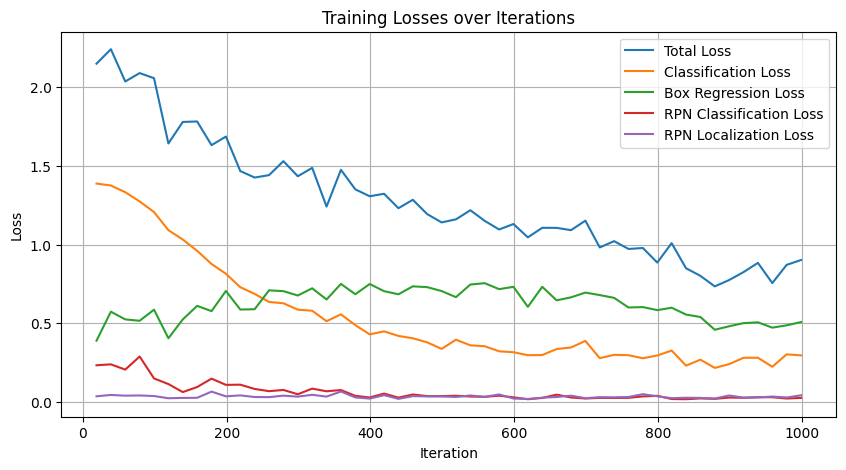

In [31]:
plt.figure(figsize=(10, 5))

# Plot total loss
plt.plot(metrics_df['iteration'], metrics_df['total_loss'], label='Total Loss')
plt.plot(metrics_df['iteration'], metrics_df['loss_cls'], label='Classification Loss')
plt.plot(metrics_df['iteration'], metrics_df['loss_box_reg'], label='Box Regression Loss')
plt.plot(metrics_df['iteration'], metrics_df['loss_rpn_cls'], label='RPN Classification Loss')
plt.plot(metrics_df['iteration'], metrics_df['loss_rpn_loc'], label='RPN Localization Loss')

plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Losses over Iterations')
plt.legend()
plt.grid(True)
plt.show()


### Evaluating

In [32]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("zindi_val_ds_", (), False, output_dir="./output_splited/")
test_loader = build_detection_test_loader(cfg, "zindi_val_ds_")
inference_on_dataset(trainer.model, test_loader, evaluator)

WARNING [06/23 17:45:36 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/23 17:45:36 d2.data.datasets.coco]: Loaded 493 images in COCO format from /kaggle/working/val_annotations.json
[06/23 17:45:36 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[06/23 17:45:36 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[06/23 17:45:36 d2.data.common]: Serializing 493 elements to byte tensors and concatenating them all ...
[06/23 17:45:36 d2.data.common]: Serialized dataset takes 0.38 MiB
[06/23 17:45:36 d2.evaluation.evaluator]: Start inference on 493 batches


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[06/23 17:45:38 d2.evaluation.evaluator]: Inference done 11/493. Dataloading: 0.0015 s/iter. Inference: 0.0760 s/iter. Eval: 0.0004 s/iter. Total: 0.0779 s/iter. ETA=0:00:37
[06/23 17:45:43 d2.evaluation.evaluator]: Inference done 77/493. Dataloading: 0.0019 s/iter. Inference: 0.0739 s/iter. Eval: 0.0004 s/iter. Total: 0.0763 s/iter. ETA=0:00:31
[06/23 17:45:48 d2.evaluation.evaluator]: Inference done 142/493. Dataloading: 0.0023 s/iter. Inference: 0.0739 s/iter. Eval: 0.0004 s/iter. Total: 0.0767 s/iter. ETA=0:00:26
[06/23 17:45:53 d2.evaluation.evaluator]: Inference done 207/493. Dataloading: 0.0023 s/iter. Inference: 0.0741 s/iter. Eval: 0.0004 s/iter. Total: 0.0769 s/iter. ETA=0:00:21
[06/23 17:45:58 d2.evaluation.evaluator]: Inference done 274/493. Dataloading: 0.0023 s/iter. Inference: 0.0738 s/iter. Eval: 0.0004 s/iter. Total: 0.0765 s/iter. ETA=0:00:16
[06/23 17:46:03 d2.evaluation.evaluator]: Inference done 341/493. Dataloading: 0.0023 s/iter. Inference: 0.0735 s/iter. Eval: 0

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[06/23 17:46:14 d2.evaluation.evaluator]: Total inference time: 0:00:37.134383 (0.076095 s / iter per device, on 1 devices)
[06/23 17:46:14 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:35 (0.073374 s / iter per device, on 1 devices)
[06/23 17:46:15 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[06/23 17:46:15 d2.evaluation.coco_evaluation]: Saving results to ./output_splited/coco_instances_results.json
[06/23 17:46:15 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.06s)
creating index...
index created!
[06/23 17:46:15 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[06/23 17:46:15 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.34 seconds.
[06/23 17:46:15 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[06/23 17:46:15 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.07 seconds.
 Average Precisi

OrderedDict([('bbox',
              {'AP': 16.841237358108614,
               'AP50': 30.427766685052692,
               'AP75': 17.61498153412896,
               'APs': 14.091900343341834,
               'APm': 17.45213411640951,
               'APl': 19.938900836199473,
               'AP-other': 0.0,
               'AP-tin': 47.031457254033384,
               'AP-thatch': 3.4922548202924535})])

`OrderedDict([('bbox',
              {'AP': 26.133858841344754,
               'AP50': 43.12796109281496,
               'AP75': 29.61674556771045,
               'APs': 22.633337972015006,
               'APm': 25.141679605373636,
               'APl': 40.638067589658334,
               'AP-other': 0.6952970297029704,
               'AP-tin': 56.14915102234668,
               'AP-thatch': 21.55712847198461})])`

----
<h3><center>-Tuning Detectron2 [Takes too long!!] </center><h3>
<h3><center>-- Code Below --</center><h3>

In [33]:
# ! pip install ray[tune]


In [34]:
# import os
# from detectron2.engine import DefaultTrainer
# from detectron2.config import get_cfg
# from detectron2.evaluation import COCOEvaluator
# from detectron2.data.datasets import register_coco_instances
# from ray import tune
# # Register the train dataset
# # register_coco_instances(
# #     "zindi_train_ds_", {}, 
# #     "/kaggle/working/train_annotations.json", 
# #     "/kaggle/input/arm-unicef-disaster-vulnerability-challenge-data/Images"
# # )

# # # Register the val dataset
# # register_coco_instances(
# #     "zindi_val_ds_", {}, 
# #     "/kaggle/working/val_annotations.json", 
# #     "/kaggle/input/arm-unicef-disaster-vulnerability-challenge-data/Images"
# # )

# def train_model(config):
#     cfg = get_cfg()
#     cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))    
#     # Set hyperparameters from Ray Tune config
#     cfg.SOLVER.BASE_LR = config["lr"]
#     cfg.SOLVER.IMS_PER_BATCH = config["ims_per_batch"]
#     cfg.SOLVER.MAX_ITER = config["max_iter"]
#     cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = config["batch_size_per_image"]
#     cfg.MODEL.RPN.NMS_THRESH = config["rpn_nms_thresh"]
#     cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = config["roi_heads_score_thresh"]

#     cfg.DATASETS.TRAIN = ("zindi_train_ds_",)
#     cfg.DATASETS.TEST = ("zindi_val_ds_",)
#     cfg.DATALOADER.NUM_WORKERS = 2
# #     cfg.MODEL.WEIGHTS = "detectron2://ImageNetPretrained/MSRA/R-50.pkl"  # Pretrained weights
#     cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo

#     cfg.SOLVER.STEPS = []  # Disable learning rate decay
#     cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3  # Number of classes
#     cfg.OUTPUT_DIR = f'./output_raytune_{config["trial_id"]}'
#     os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

#     # Create a custom trainer to log metrics to TensorBoard and save model checkpoints
#     class CustomTrainer(DefaultTrainer):
#         @classmethod
#         def build_evaluator(cls, cfg, dataset_name):
#             return COCOEvaluator(dataset_name, cfg, True, output_dir=cfg.OUTPUT_DIR)

#     # Train the model
#     trainer = CustomTrainer(cfg)
#     trainer.resume_or_load(resume=False)
#     trainer.train()

#     # Evaluate the model
#     evaluator = COCOEvaluator("zindi_val_ds_", cfg, False, output_dir=cfg.OUTPUT_DIR)
#     val_loader = build_detection_test_loader(cfg, "zindi_val_ds_")
#     metrics = inference_on_dataset(trainer.model, val_loader, evaluator)
    
#     # Get the evaluation metric (e.g., AP)
#     tune.report(AP=metrics["bbox"]["AP"], )

# search_space = {
#     "lr": tune.loguniform(1e-5, 1e-3),
#     "ims_per_batch": tune.choice([2, 4, 6, 8]),
#     "max_iter": tune.choice([1000, 5000, 10000, 20000, 30000]),
#     "batch_size_per_image": tune.choice([64, 128, 256]),
#     "rpn_nms_thresh": tune.uniform(0.5, 0.9),
#     "roi_heads_score_thresh": tune.uniform(0.5, 0.9),
#     "trial_id": tune.sample_from(lambda spec: str(spec.config.trial_id))
# }

# analysis = tune.run(
#     train_model,
#     config=search_space,
#     num_samples=20,
#     resources_per_trial={"cpu": 2, "gpu": 1}
# )

# print("Best hyperparameters found were: ", analysis.best_config)


---
<center><h3>This notebook was based on this starter work:</h3> <a href="https://www.kaggle.com/code/glebbuzin/training-detectron2-on-custom-dataset">https://www.kaggle.com/code/glebbuzin/training-detectron2-on-custom-dataset</a></center>


<h1><center>Thanks for checking the notebook! I hope it was helpful! <b>Feel Free to upvote</b></center><h1>